+ Pixelized shear measurements (smoothing -> pixelize/ pixelize -> smoothing)
+ Get the variance map (mock/analytical)

In [1]:
%pylab inline
import os
import gc
import matplotlib
import numpy as np
import astropy.io.fits as pyfits
import astropy.table as astTab
import massmap_utilities as mutilities
from configparser import ConfigParser
from pixel3D import cartesianGrid3D
from scipy.stats import norm as statnorm
import haloSim

Populating the interactive namespace from numpy and matplotlib


In [7]:
configName  =   'wrkDir/config-nl1.ini'
parser      =   ConfigParser()
parser.read(configName)
outDir      =   'wrkDir/pixel2D/'

In [8]:
def plotHist(fieldname,array,pixels,oname):
    oname=os.path.join(outDir,oname)
    cmap=plt.get_cmap('tab20')

    plt.figure(figsize=(8,6))

    gbin=plt.hist(array,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='galaxy',color=cmap(0))[1]
    gbinGal=(gbin-np.average(array))/np.std(array)
    a=statnorm.pdf(gbinGal)
    plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(0),ls='--')

    gbin=plt.hist(pixels,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='pixel',color=cmap(2))[1]

    gbinPix=(gbin-np.average(pixels))/np.std(pixels)
    a=statnorm.pdf(gbinPix)
    plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(2),ls='--')
    plt.title('%s' %fieldname,fontsize=20)
    plt.xlabel(r'$\delta g_1$',fontsize=20)
    plt.ylabel(r'$P(\delta g_1)$',fontsize=20)
    plt.legend(fontsize=20)
    plt.yscale('log')
    plt.ylim(1e-4,15)
    plt.grid()
    plt.tight_layout()
    plt.savefig(oname,overwrite=True)
    plt.close()
    return

In [10]:
mskLim=1.
for fieldname in mutilities.field_names:
    infname='wrkDir/reGaus_catalog/%s.fits' %(fieldname)
    data=pyfits.getdata(infname)
    aveWeight=np.average(data['weight'])
    if fieldname=='VVDS':
        addR=(data['ra']<300.).astype(int)*360
        data['ra']+=addR
    #head=pyfits.getheader(infname,ext=1)
    raMin=(np.min(data['ra'])-3.)*60.
    raMax=(np.max(data['ra'])+3.)*60.
    decMin=(np.min(data['dec'])-3.)*60.
    decMax=(np.max(data['dec'])+3.)*60.
    nx=int((raMax-raMin+1)//2*2)
    ny=int((decMax-decMin+1)//2*2)
    print(raMin,decMin)
    parser.set('transPlane','xmin','%s'%raMin)
    parser.set('transPlane','ymin','%s'%decMin)
    parser.set('transPlane','nx','%d'%nx)
    parser.set('transPlane','ny','%d'%ny)
    gridInfo    =   cartesianGrid3D(parser)
    x,y,z=data['ra'],data['dec'],data['dnn_zbest']
    v=data['g1']+1j*data['g2']
    ws=data['weight']
    # w*g1,w*g2,w for each pixel
    g1OutTmp=numpy.histogramdd((z,y,x),bins=(gridInfo.zbound,gridInfo.ybound,gridInfo.xbound), weights=v.real*ws)[0]
    g2OutTmp=numpy.histogramdd((z,y,x),bins=(gridInfo.zbound,gridInfo.ybound,gridInfo.xbound), weights=v.imag*ws)[0]
    weightOutTmp=numpy.histogramdd((z,y,x),bins=(gridInfo.zbound,gridInfo.ybound,gridInfo.xbound), weights=ws)[0]
    mask0=weightOutTmp>0. # the mask before smoothing
    assert weightOutTmp.shape==gridInfo.shape,'the output shape is different from expectation?'
    # variance
    sigma2=np.zeros(gridInfo.shape)
    sigma2[mask0]=1./weightOutTmp[mask0]
    if gridInfo.sigma>0:
        # Gaussian Kernel in Fourier space (normalized in configuration space)
        gausKer=haloSim.GausAtom(ny=ny,nx=nx,sigma=gridInfo.sigma/gridInfo.delta,fou=True,lnorm=2.)
        norm=gausKer[0,0]
        gausKer/=norm
        
        # Gaus**2. in Fourier space
        gausKer2=haloSim.GausAtom(ny=ny,nx=nx,sigma=gridInfo.sigma/gridInfo.delta,fou=False,lnorm=1.)
        gausKer2=gausKer2**2.
        gausKer2=np.fft.fft2(gausKer2)
        
        # smothing with Gausian Kernel
        g1OutTmp=np.fft.ifft2(np.fft.fft2(g1OutTmp)*gausKer).real
        g2OutTmp=np.fft.ifft2(np.fft.fft2(g2OutTmp)*gausKer).real
        weightOut=np.fft.ifft2(np.fft.fft2(weightOutTmp)*gausKer).real
        sigma2Out=np.fft.ifft2(np.fft.fft2(sigma2)*gausKer2).real
        gausKerCon=np.fft.ifft2(np.fft.fft2(mask0.astype(float))*gausKer).real
    
    g1OutTmp/=aveWeight
    g2OutTmp/=aveWeight
    weightOut/=aveWeight
    mask=weightOut>mskLim
    sigma2Out[~mask]=0.
    sigma2Out[mask]=sigma2Out[mask]/gausKerCon[mask]**2.
    g1Out=np.zeros(gridInfo.shape)
    g1Out[mask]=g1OutTmp[mask]/weightOut[mask]
    g2Out=np.zeros(gridInfo.shape)
    g2Out[mask]=g2OutTmp[mask]/weightOut[mask]
    pyfits.writeto(os.path.join(outDir,'%s_dnnz_10_bins_g1Map.fits' %fieldname),g1Out,overwrite=True)
    pyfits.writeto(os.path.join(outDir,'%s_dnnz_10_bins_g2Map.fits' %fieldname),g2Out,overwrite=True)
    pyfits.writeto(os.path.join(outDir,'%s_dnnz_10_bins_weightMap.fits' %fieldname),weightOut,overwrite=True)
    pyfits.writeto(os.path.join(outDir,'%s_dnnz_10_bins_std.fits' %fieldname),np.sqrt(sigma2Out),overwrite=True)
    
    varOut=np.zeros(gridInfo.shape,dtype=float)
    plotHist(fieldname,data['g1'],g1Out[mask],'%s_dnnz_10_bins_hist.png' %fieldname)
    del g1Out,g2Out,weightOut
    gc.collect()

1565.6270882643867 -563.4529855801278


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


7511.884040200001 -293.94776607479395


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


9056.585232079698 -280.5903829327962


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


12186.362086594861 -282.723704951773


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


19648.172504524035 -240.3134553150722


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


12574.431102030565 2352.7539675342996


/home/xiangchong/work/ana/lsstsw/miniconda/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error two minor releases later


In [5]:
gausKer2=haloSim.GausAtom(ny=ny,nx=nx,sigma=gridInfo.sigma/gridInfo.delta,fou=False,lnorm=1.)

In [6]:
np.sum(gausKer2)

1.0000000000000002

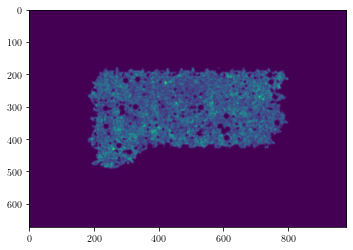

In [4]:
plt.imshow(weightOut[0])
pyfits.writeto('b.fits',weightOut,overwrite=True)

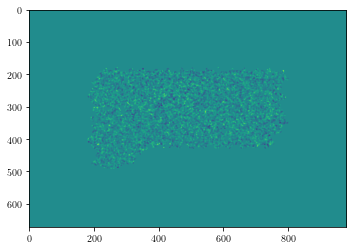

In [6]:
plt.imshow(g1Out[0])
pyfits.writeto('a.fits',g1Out,overwrite=True)

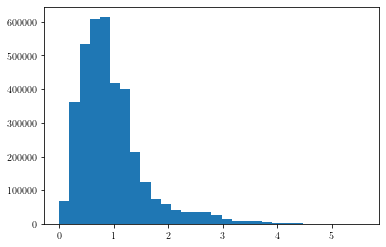

In [6]:
a=plt.hist(data['dnn_zbest'],bins=30)

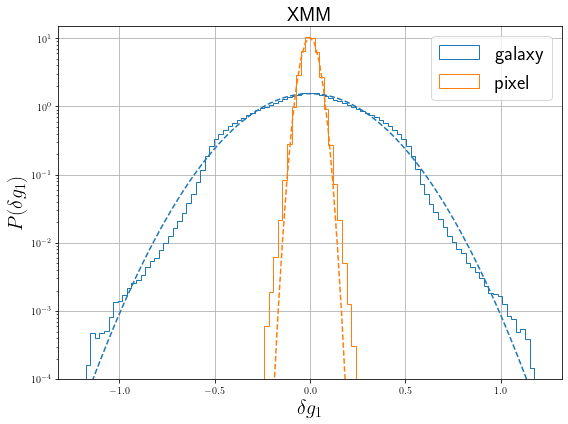

In [15]:
cmap=plt.get_cmap('tab20')

plt.figure(figsize=(8,6))

gbin=plt.hist(data['g1'],bins=100,density=True,range=(-1.2,1.2),histtype='step',label='galaxy',color=cmap(0))[1]
gbinGal=(gbin-np.average(data['g1']))/np.std(data['g1'])
a=statnorm.pdf(gbinGal)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(0),ls='--')

g1pixAll=g1Out[mask]
gbin=plt.hist(g1pixAll,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='pixel',color=cmap(2))[1]

gbinPix=(gbin-np.average(g1pixAll))/np.std(g1pixAll)
a=statnorm.pdf(gbinPix)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(2),ls='--')
plt.title('%s' %fieldname,fontsize=20)
plt.xlabel(r'$\delta g_1$',fontsize=20)
plt.ylabel(r'$P(\delta g_1)$',fontsize=20)
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(1e-4,15)
plt.grid()
plt.tight_layout()

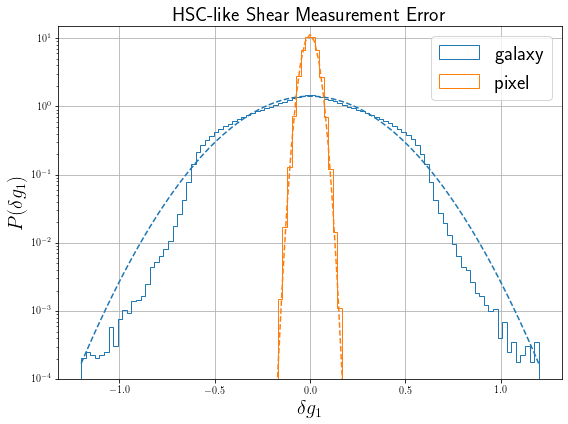

In [79]:
# simulation results
plt.savefig('../doc/paper_ms_method_HSCY1/shapeMeasurementError-HSCY1.pdf')